In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import ot
import scipy
from numpyro import diagnostics, distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import initialize_model
from scipy import stats

from mcmc import run_sortmc


jnp.set_printoptions(precision=4, suppress=True)
jax.config.update("jax_enable_x64", True)


def log_p_normal(x):
    return 0.5 * jnp.dot(x, x)


STD_X = 3.0


def std_y(x):
    return jnp.exp(jax.lax.stop_gradient(x) / 2.0)


@jax.jit
def potential_funnel(x):
    z_term = x[0] ** 2 / (2.0 * STD_X**2)
    y_term = jnp.sum(x[1:] ** 2) / (2.0 * std_y(x[0]) ** 2)
    return z_term + y_term


def funnel_model(dim=10):
    x = numpyro.sample("x", dist.Normal(jnp.zeros((1,)), STD_X))
    numpyro.sample("y", dist.Normal(jnp.zeros(dim - 1), std_y(x)))


def dict_to_array(dct: dict):
    x = jnp.expand_dims(dct["x"], dct["x"].ndim)
    return jnp.concatenate([x, dct["y"]], axis=-1)


@jax.jit
@jax.vmap
def funnel_true_samples(keys):
    key_x, key_y = jr.split(keys, 2)
    x = jr.normal(key_x, shape=(1,)) * STD_X
    y = jr.normal(key_y, shape=(9,)) * std_y(x)
    return jnp.concatenate([x, y])


def rescale_funnel(x):
    return jnp.concatenate([x[:1] / STD_X, x[1:] / std_y(x[0])])


vec_rescale_funnel = jax.jit(jax.vmap(rescale_funnel, in_axes=0))

x0_funnel = jnp.zeros((10,), dtype=jnp.float64)


FUNNEL_LIMS = (-10.0, 10.0)


def draw_funnel(samples):
    samples_rshp = jnp.reshape(samples, (-1, 10))
    fig, ax = plt.subplots(1, 1)
    ax.scatter(samples_rshp[:, 0], samples_rshp[:, 1], alpha=0.2, s=8.0)
    ax.set(xlim=FUNNEL_LIMS, ylim=FUNNEL_LIMS)
    plt.show()


def evaluate_funnel(samples, grad_evals_per_sample: float = 0.0):
    def avg(x):
        x = jnp.array(x)
        weights = jnp.array([9] + [1] * 9, dtype=jnp.float64) / 18.0
        return jnp.dot(x, weights)

    def matrix_avg(x):
        x = jnp.array(x)
        one_dim = jax.vmap(avg, in_axes=0)(x)
        return avg(one_dim)

    samples_rshp = jnp.reshape(samples, (-1, 10))
    means = jnp.mean(samples_rshp, axis=0)
    max_mean_err = jnp.max(jnp.abs(means))
    avg_mean_err = avg(jnp.abs(means))
    samples_rescaled = vec_rescale_funnel(samples_rshp)
    cov = jnp.cov(samples_rescaled, rowvar=False)
    cov_err = jnp.abs(cov - jnp.eye(10))
    max_cov_err = jnp.max(cov_err)
    avg_cov_err = matrix_avg(cov_err)
    ref_dist = stats.norm(loc=0.0, scale=1.0)
    pvals = []
    for i in range(10):
        _, pval = stats.kstest(samples_rescaled[:, i], ref_dist.cdf)
        pvals.append(pval)
    min_pval = min(pvals)
    avg_pval = avg(pvals)
    if samples.ndim > 2:
        ess = diagnostics.effective_sample_size(samples) / samples_rshp.shape[0]
        min_ess = jnp.min(ess)
        avg_ess = avg(ess)
        # compute the number of gradient evaluations per effective sample
        if grad_evals_per_sample > 0:
            gepes = grad_evals_per_sample / avg_ess
            print(f"Gradient evaluations per effective sample: {gepes}")
    else:
        ess = 1.0
        min_ess = 1.0
        avg_ess = 1.0
    print(
        f"Max mean err: {max_mean_err:.4}, max cov err: {max_cov_err:.4},"
        f" min_pval: {min_pval:.4}, min_ess {min_ess:.4}"
    )
    print(
        f"Avg mean err: {avg_mean_err:.4}, avg cov err: {avg_cov_err:.4},"
        f" avg_pval: {avg_pval:.4}, avg_ess {avg_ess:.4}"
    )

    draw_funnel(samples_rshp)

    return means, cov, pvals, ess

In [4]:
# geps stands for gradient evals per sample
ys_funnel_sort, geps_sort = run_sortmc(
    jr.PRNGKey(0),
    potential_funnel,
    x0_funnel,
    64,
    2**7,
    2.0,
    2.0**-6,
    warmup_mult=16.0,
    warmup_tol_mult=4.0,
)

Steps warmup: 83.984375, steps mcmc: 1194.28125, gradient evaluations per output: 59.918701171875


In [9]:
num_chains = 64
x0_funnel_broadcast = jnp.broadcast_to(x0_funnel, (num_chains,) + x0_funnel.shape)

kernel = NUTS(funnel_model, step_size=2.0)
nuts_funnel = MCMC(
    kernel,
    num_warmup=16,
    num_samples=2**7,
    num_chains=num_chains,
    chain_method="vectorized",
)
nuts_funnel.run(
    jr.PRNGKey(0),
    extra_fields=("num_steps",),
    init_params={
        "x": np.zeros((num_chains,), dtype=np.float64),
        "y": np.zeros((num_chains, 9), dtype=np.float64),
    },
)
ys_funnel_nuts_dict = nuts_funnel.get_samples(group_by_chain=True)
ys_funnel_nuts = dict_to_array(ys_funnel_nuts_dict)
steps_nuts = nuts_funnel.get_extra_fields()["num_steps"]
geps_nuts = sum(steps_nuts) / len(steps_nuts)
print(geps_nuts)

sample: 100%|██████████| 144/144 [00:33<00:00,  4.31it/s]


In [19]:
print(geps_nuts)

700.187744140625


In [2]:
ys_funnel_euler, geps_euler = run_sortmc(
    jr.PRNGKey(0),
    potential_funnel,
    x0_funnel,
    64,
    2**7,
    2.0,
    2.0**-6,
    warmup_mult=16.0,
    warmup_tol_mult=4.0,
    use_sort_adaptive=False,
)

Steps warmup: 512.0, steps mcmc: 17022.0, gradient evaluations per output: 136.984375


Gradient evaluations per effective sample: 34038.734547681976
Max mean err: 0.7929, max cov err: 0.556, min_pval: 8.035e-219, min_ess 0.009243
Avg mean err: 0.436, avg cov err: 0.1554, avg_pval: 0.04434, avg_ess 0.02057


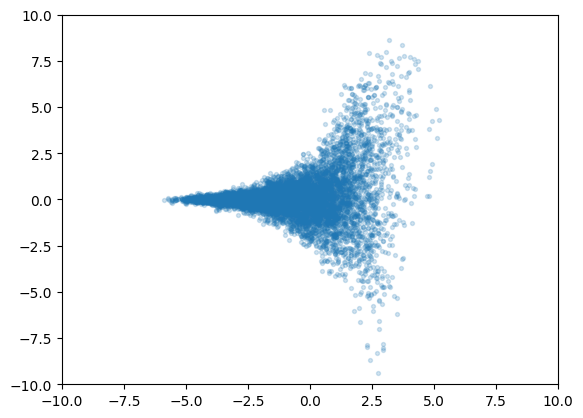

700.187744140625


In [12]:
_ = evaluate_funnel(ys_funnel_nuts, geps_nuts)
# ani_nuts, _, _ = animated_funnel_plot(ys_funnel_nuts)
# ani_nuts.save("funnel_nuts.gif", writer="pillow")
print(geps_nuts)

Gradient evaluations per effective sample: 722.2254415230492
Max mean err: 0.51, max cov err: 6.525e+04, min_pval: 0.0, min_ess 0.1228
Avg mean err: 0.133, avg cov err: 5.062e+03, avg_pval: 0.1907, avg_ess 0.1897


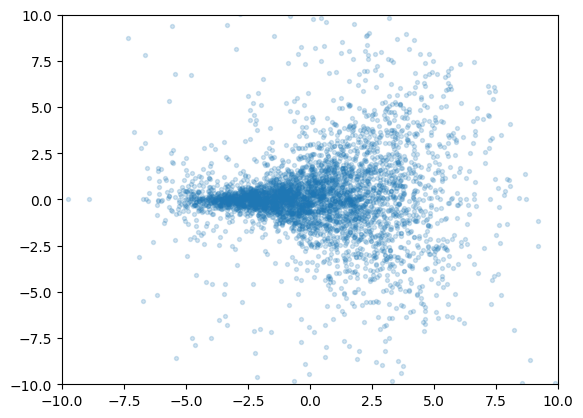

In [5]:
ys_funnel_euler = jnp.clip(ys_funnel_euler, -20, 20)

_ = evaluate_funnel(ys_funnel_euler, geps_euler)
# ani_euler, _, _ = animated_funnel_plot(ys_funnel_euler)
# ani_euler.save("funnel_euler.gif", writer="pillow")

Gradient evaluations per effective sample: 451.0969777610236
Max mean err: 0.2011, max cov err: 0.344, min_pval: 1.483e-18, min_ess 0.1226
Avg mean err: 0.04709, avg cov err: 0.02871, avg_pval: 0.1741, avg_ess 0.1328


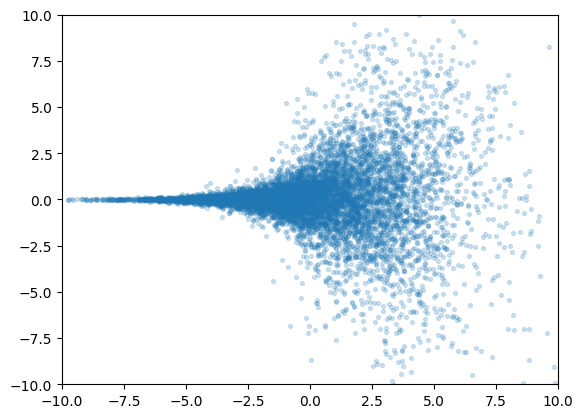

In [13]:
_ = evaluate_funnel(ys_funnel_sort, geps_sort)
# ani_sort, _, _ = animated_funnel_plot(ys_funnel_sort)
# ani_sort.save("funnel_sort.gif", writer="pillow")

Max mean err: 0.08001, max cov err: 0.03848, min_pval: 0.1341, min_ess 1.0
Avg mean err: 0.02212, avg cov err: 0.005724, avg_pval: 0.5594, avg_ess 1.0


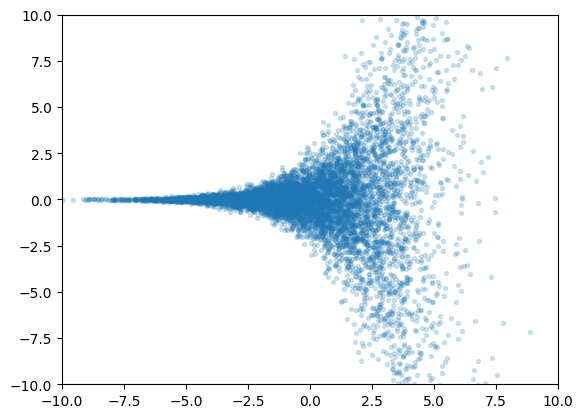

In [42]:
# True samples
keys = jr.split(jr.PRNGKey(0), 2**13)
ys_funnel_true = funnel_true_samples(keys)
_ = evaluate_funnel(ys_funnel_true)

In [1]:
def get_model_and_data(data, name):
    dset = data[name][0, 0]
    x = dset["x"]
    labels = dset["t"]
    n, data_dim = x.shape
    n_train = min(int(n / 2), 500)
    x_train = x[:n_train]
    labels_train = labels[:n_train]
    x_test = x[n_train:]
    labels_test = labels[n_train:]

    def model():
        alpha = numpyro.sample("alpha", dist.Exponential(0.01))
        W = numpyro.sample("W", dist.Normal(jnp.zeros(data_dim), 1.0 / alpha))
        logits = jnp.sum(W * x_train, axis=-1)
        return numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=labels_train)

    return model, (x_train, labels_train, x_test, labels_test)


data = scipy.io.loadmat("mcmc_data/benchmarks.mat")

model_logreg, data_split = get_model_and_data(data, "banana")

logreg_info = initialize_model(jr.PRNGKey(0), model_logreg)


def dict_to_array(dct: dict):
    alpha = dct["alpha"]

    return jnp.concatenate([jnp.expand_dims(alpha, alpha.ndim), dct["W"]], axis=-1)


vec_dict_to_array = jax.vmap(dict_to_array, in_axes=0, out_axes=0)


def array_to_dict(arr: jnp.ndarray):
    return {"alpha": arr[0], "W": arr[1:]}


@jax.jit
def potential_fn(arr: jnp.ndarray):
    dct = array_to_dict(arr)
    return logreg_info.potential_fn(dct)


arr0 = dict_to_array(logreg_info.param_info.z)

print(jax.devices("cuda"))

NameError: name 'scipy' is not defined

In [3]:
out_logreg_sort, steps_logreg_sort = run_sortmc(
    jr.PRNGKey(0),
    potential_fn,
    arr0,
    64,
    2**7,
    1.0,
    0.25,
    warmup_mult=8.0,
    warmup_tol_mult=4.0,
)
print(out_logreg_sort.shape)

Steps warmup: 128.0, steps mcmc: 8510.609375, steps per output: 67.4891357421875
(64, 128, 3)


In [4]:
def compute_w2(x1, x2):
    source_samples = np.array(x1)
    target_samples = np.array(x2)
    source_weights = np.ones(source_samples.shape[0]) / source_samples.shape[0]
    target_weights = np.ones(target_samples.shape[0]) / target_samples.shape[0]
    mm = ot.dist(source_samples, target_samples)
    return ot.emd2(source_weights, target_weights, mm)


def eval_logreg(samples, evals_per_sample, ground_truth=None):
    if isinstance(samples, dict):
        samples = vec_dict_to_array(samples)
    ess = diagnostics.effective_sample_size(samples)
    print(f"Gradient evals per effective sample: {evals_per_sample/ess}")
    if ground_truth is None:
        return
    sample_dim = samples.shape[-1]
    reshaped = jnp.reshape(samples, (-1, sample_dim))

    w2 = compute_w2(reshaped, ground_truth)
    print(f"W2 distance: {w2}")

In [5]:
nuts = MCMC(
    NUTS(model_logreg),
    num_warmup=2**3,
    num_samples=2**7,
    num_chains=64,
    chain_method="vectorized",
)
gt_nuts = MCMC(NUTS(model_logreg, step_size=0.25), num_warmup=2**8, num_samples=2**14)

In [6]:
nuts.run(jr.PRNGKey(0), extra_fields=("num_steps",))
out_logreg_nuts = nuts.get_samples(group_by_chain=True)
num_steps_nuts = nuts.get_extra_fields()["num_steps"]
geps_nuts = sum(num_steps_nuts) / len(num_steps_nuts)

sample: 100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


In [7]:
eval_logreg(out_logreg_nuts, geps_nuts)
eval_logreg(out_logreg_sort, steps_logreg_sort)

Gradient evals per effective sample: [  nan   nan 0.355]
Gradient evals per effective sample: [0.0625 0.0092 0.0072]


In [8]:
gt_nuts.run(jr.PRNGKey(0))
gt_logreg = vec_dict_to_array(gt_nuts.get_samples())

sample: 100%|██████████| 16640/16640 [01:20<00:00, 207.40it/s, 3 steps of size 3.38e-01. acc. prob=0.92] 


In [9]:
def run_logreg_dataset(name):
    model_logreg, data_split = get_model_and_data(data, name)
    logreg_info = initialize_model(jr.PRNGKey(0), model_logreg)
    arr0 = dict_to_array(logreg_info.param_info.z)
    out_logreg_sort, steps_logreg_sort = run_sortmc(
        jr.PRNGKey(0),
        potential_fn,
        arr0,
        64,
        2**7,
        1.0,
        2.0**-2,
        warmup_mult=8.0,
        warmup_tol_mult=4.0,
    )
    nuts = MCMC(
        NUTS(model_logreg),
        num_warmup=2**4,
        num_samples=2**7,
        num_chains=64,
        chain_method="vectorized",
    )
    nuts.run(jr.PRNGKey(0), extra_fields=("num_steps",))
    out_logreg_nuts = nuts.get_samples(group_by_chain=True)
    num_steps_nuts = nuts.get_extra_fields()["num_steps"]
    geps_nuts = sum(num_steps_nuts) / len(num_steps_nuts)
    gt_nuts = MCMC(
        NUTS(model_logreg, step_size=0.25), num_warmup=2**8, num_samples=2**14
    )
    gt_nuts.run(jr.PRNGKey(0))
    gt_logreg = vec_dict_to_array(gt_nuts.get_samples())
    eval_logreg(out_logreg_nuts, geps_nuts, gt_logreg)
    eval_logreg(out_logreg_sort, steps_logreg_sort, gt_logreg)